<a href="https://colab.research.google.com/github/Sergio-ddf/emit-llm/blob/main/emit_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMit Emotion Detection Task

In [ ]:
# monta la repo con PAT nascosto nei Secrets
from google.colab import userdata
import os, wandb

os.environ["WANDB_API_KEY"] = userdata.get('WANDB_KEY')
wandb.login()



wandb: Currently logged in as: ddfsergio9 (ddfsergio9-sapienza-universit-di-roma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Installazione delle dipendenze (esegui solo la prima volta)
!pip install -q datasets emoji iterative-stratification evaluate tokenizers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [ ]:
# Import principali e informazioni sull'ambiente
import os, platform, re
import numpy as np
import pandas as pd
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer)
import datasets, emoji, evaluate, tokenizers, transformers

print(f"Python     : {platform.python_version()}")
print(f"PyTorch    : {torch.__version__} (CUDA disponibile: {torch.cuda.is_available()})")
print(f"Transformers: {transformers.__version__}")
print(f"Datasets   : {datasets.__version__}")

Python     : 3.11.12
PyTorch    : 2.6.0+cu124 (CUDA disponibile: True)
Transformers: 4.51.3
Datasets   : 3.5.1


In [ ]:
# Caricamento dei file CSV
DATA_DIR = ""  # <--- modifica se i file sono in un'altra cartella

train_a = pd.read_csv(os.path.join(DATA_DIR, "emit_train_A.csv"))
train_b = pd.read_csv(os.path.join(DATA_DIR, "emit_train_B.csv"))

test_in  = pd.read_csv(os.path.join(DATA_DIR, "emit_test.csv"))

display(train_a.head())

,id,text,Anger,Anticipation,Disgust,Fear,Joy,Love,Neutral,Sadness,Surprise,Trust
0,04b19fcefed25f6919fbbb8fe6ac4f1e,RT @user: Serve aggiungere altro? #Ulisse INIZ...,0,1,0,0,1,1,0,0,0,0
1,6320e808285b5e1613dbd28580affd21,RT @user: La differenza tra chi ha studiato ed...,0,0,0,0,0,0,1,0,0,0
2,abdddf2c6231ca527bbaf808e8c11085,Metà della sobrietà di #IlariaCucchi dovrebbe ...,0,0,0,0,0,0,0,0,0,1
3,8b6a76b34ed6bdb23d61ba9ef386ecb8,LENÙ PER PIACERE SCAPPA STO IN ANSIA PER TE TI...,0,1,0,1,0,0,0,0,0,0
4,913743b451b8178fa138c7b27f26fac6,@user Nooooo!!! La signora Cecchini 😢 #DonMatt...,0,0,0,0,0,0,0,1,0,0


Trust           1665
Neutral         1322
Disgust          874
Joy              650
Love             633
Surprise         591
Anticipation     547
Sadness          545
Anger            367
Fear              91
dtype: int64


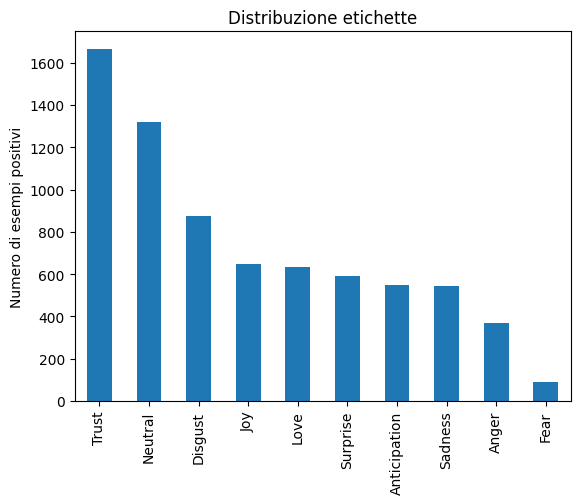

In [ ]:
# Statistiche delle etichette (frequenza nel train set)
LABELS = ['Anger','Anticipation','Disgust','Fear','Joy','Love','Neutral','Sadness','Surprise','Trust']

stats = train_a[LABELS].sum().sort_values(ascending=False)
ax = stats.plot(kind='bar', title='Distribuzione etichette')
ax.set_ylabel('Numero di esempi positivi')
print(stats)

In [ ]:
# Pre‑processing del testo: link, mention, hashtag, emoji
URL_TOKEN     = "<URL>"
USER_TOKEN    = "<USER>"
HASHTAG_TOKEN = "<HASHTAG>"


def clean(text: str) -> str:
    """Semplice pulizia del testo e sostituzione di token speciali."""
    text = re.sub(r'https?://\S+', URL_TOKEN, text)       # link
    text = re.sub(r'@\w+', USER_TOKEN, text)               # mention
    text = re.sub(r'#(\w+)', HASHTAG_TOKEN + r' \1', text) # hashtag → token + parola
    text = emoji.demojize(text, language='it')               # emoji → testo
    return text.strip()

train_a['text_clean'] = train_a['text'].apply(clean)
train_a[['text', 'text_clean']].head()

,text,text_clean
0,RT @user: Serve aggiungere altro? #Ulisse INIZ...,RT <USER>: Serve aggiungere altro? <HASHTAG> U...
1,RT @user: La differenza tra chi ha studiato ed...,RT <USER>: La differenza tra chi ha studiato e...
2,Metà della sobrietà di #IlariaCucchi dovrebbe ...,Metà della sobrietà di <HASHTAG> IlariaCucchi ...
3,LENÙ PER PIACERE SCAPPA STO IN ANSIA PER TE TI...,LENÙ PER PIACERE SCAPPA STO IN ANSIA PER TE TI...
4,@user Nooooo!!! La signora Cecchini 😢 #DonMatt...,<USER> Nooooo!!! La signora Cecchini :faccina_...


In [ ]:
# Split 90/10 stratificato con MultilabelStratifiedShuffleSplit
X = train_a['text_clean'].values
Y = train_a[LABELS].values

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
train_idx, val_idx = next(msss.split(X, Y))

train_df = train_a.iloc[train_idx].reset_index(drop=True)
val_df   = train_a.iloc[val_idx].reset_index(drop=True)

print(f"Dimensione train: {train_df.shape[0]} – validation: {val_df.shape[0]}")

Dimensione train: 5381 – validation: 585


In [ ]:
# Baseline: TF‑IDF uni/bi‑gram + Logistic Regression (One‑vs‑Rest)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5_000)

X_train = vectorizer.fit_transform(train_df['text_clean'])
X_val   = vectorizer.transform(val_df['text_clean'])

y_train = train_df[LABELS].values
y_val   = val_df[LABELS].values

clf = OneVsRestClassifier(LogisticRegression(max_iter=1_000, random_state=42))
clf.fit(X_train, y_train)

y_pred   = clf.predict(X_val)
macro_f1 = f1_score(y_val, y_pred, average='macro')
print(f"Baseline TF‑IDF + LR macro‑F1: {macro_f1:.4f}")

print(classification_report(y_val, y_pred, target_names=LABELS, zero_division=0))

Baseline TF‑IDF + LR macro‑F1: 0.1600
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00        37
Anticipation       0.71      0.09      0.16        55
     Disgust       0.00      0.00      0.00        87
        Fear       0.00      0.00      0.00         9
         Joy       0.73      0.12      0.21        65
        Love       0.72      0.21      0.32        63
     Neutral       0.70      0.14      0.24       132
     Sadness       1.00      0.09      0.17        55
    Surprise       0.80      0.07      0.12        59
       Trust       0.80      0.25      0.38       167

   micro avg       0.77      0.13      0.22       729
   macro avg       0.55      0.10      0.16       729
weighted avg       0.63      0.13      0.21       729
 samples avg       0.16      0.14      0.14       729



In [ ]:
# Preparazione dati per il fine‑tuning di UmBERTo
MODEL_NAME = 'Musixmatch/umberto-commoncrawl-cased-v1'  # puoi cambiarlo
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_LABELS  = len(LABELS)

# Calcolo dei pesi di classe per BCE ponderata
freqs        = train_df[LABELS].mean().values  # frequenza positivi per classe
pos_weights  = torch.tensor((1 - freqs) / freqs, device=DEVICE)

# Aggiungo colonna "labels" con vettore di float
for df in (train_df, val_df):
    df['labels'] = df[LABELS].astype(float).values.tolist()

# Tokenizzazione
MAX_LEN   = 128
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    enc = TOKENIZER(batch['text_clean'], padding='max_length', truncation=True, max_length=MAX_LEN)
    enc['labels'] = batch['labels']
    return enc

# Conversione in HuggingFace Dataset e formattazione "torch"
drop_cols = ['text', 'text_clean'] + LABELS

dtrain = datasets.Dataset.from_pandas(train_df).map(tokenize_fn, batched=True, remove_columns=drop_cols)
dval   = datasets.Dataset.from_pandas(val_df).map(tokenize_fn,   batched=True, remove_columns=drop_cols)

dtrain.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
dval.set_format('torch',   columns=['input_ids', 'attention_mask', 'labels'])

# Modello
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type='multi_label_classification'
).to(DEVICE)

# Mappatura etichette → id
model.config.label2id = {lbl: i for i, lbl in enumerate(LABELS)}
model.config.id2label = {i: lbl for i, lbl in enumerate(LABELS)}

# Funzione metriche (macro‑F1)
from torch.nn.functional import sigmoid

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs  = sigmoid(torch.tensor(logits))
    preds  = (probs >= 0.5).int().numpy()
    labels = labels.astype(int)
    return {"eval_macro_f1": float(f1_score(labels, preds, average='macro', zero_division=0))}

# Trainer personalizzato con BCE ponderata
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # opzionale: dreniamo num_items_in_batch se presente
        inputs.pop("num_items_in_batch", None)

        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        loss    = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)(
            logits, labels.float()
        )
        return (loss, outputs) if return_outputs else loss


# Argomenti di training
args = TrainingArguments(
    output_dir='ckpt/umberto',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    num_train_epochs=10,
    lr_scheduler_type='linear',
    warmup_steps=500,
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_macro_f1',
    report_to=None,
    run_name='umberto_full'
)

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=dtrain,
    eval_dataset=dval,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/794k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

Map:   0%|          | 0/5381 [00:00<?, ? examples/s]

Map:   0%|          | 0/585 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
# Avvio del fine‑tuning
trainer.train()
print(f"Migliore eval_macro_f1: {trainer.state.best_metric:.4f}")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ddfsergio9 (ddfsergio9-sapienza-universit-di-roma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Macro F1
1,1.174200,1.075685,0.349552
2,0.939700,0.893672,0.426273
3,0.762700,0.845078,0.439171
4,0.678700,0.851224,0.467351
5,0.549200,0.879464,0.503385
6,0.448500,0.872285,0.487315
7,0.415600,0.934768,0.525536
8,0.360100,0.982843,0.532038
9,0.328100,0.994606,0.541357
10,0.303800,1.002797,0.549251


Migliore eval_macro_f1: 0.5493


In [ ]:
# Ottimizzazione della soglia per classe e valutazione finale
# Predizioni sul validation set
eval_preds = trainer.predict(dval)
val_logits = eval_preds.predictions
val_labels = val_df[LABELS].values.astype(int)

# Calcolo probabilità
val_probs = sigmoid(torch.tensor(val_logits)).numpy()

# Ricerca della soglia ottimale per ogni classe
best_thresholds = []
for i in range(NUM_LABELS):
    best_f1, best_t = 0.0, 0.5
    for t in np.linspace(0.1, 0.9, 81):
        f1 = f1_score(val_labels[:, i], (val_probs[:, i] >= t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    best_thresholds.append(best_t)
print("Soglie ottimali per classe:", dict(zip(LABELS, best_thresholds)))

# Valutazione macro‑F1 con soglie ottimizzate
preds_opt = (val_probs >= np.array(best_thresholds)).astype(int)
final_macro = f1_score(val_labels, preds_opt, average='macro', zero_division=0)
print(f"Macro‑F1 finale ottimizzata: {final_macro:.4f}")

Soglie ottimali per classe: {'Anger': np.float64(0.71), 'Anticipation': np.float64(0.74), 'Disgust': np.float64(0.45999999999999996), 'Fear': np.float64(0.9), 'Joy': np.float64(0.88), 'Love': np.float64(0.6799999999999999), 'Neutral': np.float64(0.63), 'Sadness': np.float64(0.76), 'Surprise': np.float64(0.66), 'Trust': np.float64(0.58)}
Macro‑F1 finale ottimizzata: 0.5883
